# Deep Learning - Report 1

## CIFAR-10
We are going to work on the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) [Krizhevsky 2009].

For the purpose of testing your skills, we are going to directly download an original dataset and manually adapt it to the PyTorch format. The following three cells download the data, create NumPy arrays of them, and show examples. The `load_cifar10` function converts the color images to gray-scale ones when `color=False`.

[Krizhevsky 2009] [Learning Multiple Layers of Features from Tiny Images, Alex Krizhevsky, 2009.](https://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf)

In [22]:
import pickle
import numpy as np
import urllib.request
import tarfile
import os.path
from pathlib import Path

def download_cifar10():
    filename = 'cifar-10.tar.gz'
    if os.path.isfile(filename):
        print(f'{filename} already exists. Skipping downloading.')
        return

    url = 'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'

    with urllib.request.urlopen(url) as testfile, open('cifar-10.tar.gz', 'wb') as f:
        f.write(testfile.read())


def extract_cifar10(filename="cifar-10.tar.gz"):
    dirname = 'cifar-10-batches-py'
    if Path(dirname).is_dir():
        print(f'{dirname} already exists. Skipping extracting.')
        return

    tar = tarfile.open(filename)
    tar.extractall()
    tar.close()


def load_cifar10(train, dir='cifar-10-batches-py', color=False):
    data_raw = []
    if train:
        for i in range(5):
            with open(f'{dir}/data_batch_{i+1}', 'rb') as f:
                data_raw.append(pickle.load(f, encoding='bytes'))
        x = np.concatenate(
            [d[b'data'] for d in data_raw],
            axis=0)
        y = np.concatenate(
            [d[b'labels'] for d in data_raw],
            axis=0)
    else:
        with open(f'{dir}/test_batch', 'rb') as f:
            data_raw = pickle.load(f, encoding='bytes')
        x = np.array(data_raw[b'data'])
        y = np.array(data_raw[b'labels'])

    x = np.reshape(x, newshape=(len(x), 3, 32, 32))
    if not color:
        x = x.mean(axis=1, keepdims=True)  # Convert Red-Green-Blue (RGB) images to gray-scale.
    return x, y

In [23]:
download_cifar10()
extract_cifar10()
x_train_val_np, y_train_val_np = load_cifar10(train=True)
x_test_np, y_test_np = load_cifar10(train=False)

cifar-10.tar.gz already exists. Skipping downloading.
cifar-10-batches-py already exists. Skipping extracting.


['truck', 'truck', 'deer', 'automobile', 'automobile']


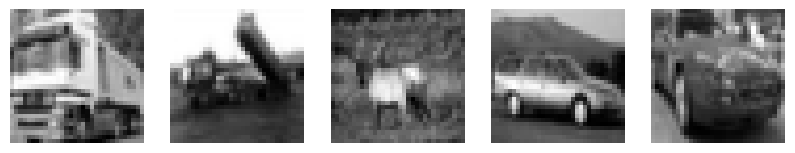

In [24]:
import matplotlib.pyplot as plt

id2class = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}

def plot_images(x, y, rows=1, cols=5, color=False):
    figure = plt.figure(figsize=(2 * cols, 2 * rows))
    ys = []
    for i in range(rows):
        for j in range(cols):
            k = (i * cols) + j + 1
            figure.add_subplot(rows, cols, k)
            plt.axis("off")
            if color:
                plt.imshow(np.transpose(x[k], [1, 2, 0]))
            else:
                plt.imshow(np.transpose(x[k], [1, 2, 0]), cmap="gray")
            ys.append(y[k])
    print([id2class[id] for id in ys])
    plt.show()

plot_images(x_train_val_np, y_train_val_np, rows=1, cols=5)

## Exercise 1
Randomly split the dataset `(x_train_val_np, y_train_val_np)` to a training set `(x_train_np, y_train_np)` and a validation set `(x_val_np, y_val_np)`. Here, take `40000` data points for the training set and put the rest in the validation set.

In [25]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [26]:
### Solution to Exercise 1

from sklearn.model_selection import train_test_split

#Creation of dataset for training and validation
x_train_np, x_val_np, y_train_np, y_val_np = train_test_split(
    x_train_val_np, y_train_val_np, train_size=40_000, 
    stratify=y_train_val_np, random_state=42)

## Exercise 2
Write code to convert `x_train_np, y_train_np, x_val_np, y_val_np, x_test_np, y_test_np` to PyTorch Tensors.
Name the tensors as `x_train, y_train, x_val, y_val, x_test, y_test`, respectively.

**Note**: You may need to explicitly change the `dtype` of your tensors. PyTorch by default requires the type (`dtype`) of input tensor to be `torch.float32` and that of the labels to be `torch.int64`.

In [27]:
### Solution to Exercise 2

import torch

#transformation of data to tensor for manipulation with PyTorch
x_train = torch.from_numpy(x_train_np).to(dtype=torch.float32)
y_train = torch.from_numpy(y_train_np).to(dtype=torch.int64)

x_val = torch.from_numpy(x_val_np).to(dtype=torch.float32)
y_val = torch.from_numpy(y_val_np).to(dtype=torch.int64)

x_test = torch.from_numpy(x_test_np).to(dtype=torch.float32)
y_test = torch.from_numpy(y_test_np).to(dtype=torch.int64)

## Exercise 3
Write a Python class `CustomDataset` deriving `torch.utils.data.Dataset` and create dataloaders for the training, validation, and test sets.

**Bonus** If possible, making the `transform` parameter and pass `ToTensor()` to it to avoid manually converting data to PyTorch tensors as in Exercise 2.

In [28]:
### Solution to Exercise 3

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

#Class CustomDataset for facilitate data management and loading
class CustomDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        data_point = self.x[idx]
        label = self.y[idx]
        return data_point, label

In [29]:
### Solution to Exercise 3

#Creation of dataloader for training, validation and test sets
train_dataloader = DataLoader(CustomDataset(x_train, y_train), batch_size=64, shuffle=True)
validation_dataloader = DataLoader(CustomDataset(x_val, y_val), batch_size=64, shuffle=True)
test_dataloader = DataLoader(CustomDataset(x_test, y_test), batch_size=64, shuffle=True)

## Exercise 4
Let the variable `device` be `'cuda'` if CUDA (GPU) is available. Otherwise, let it be `'cpu'`.
(Do **not** move the tensors from Exercise 1 to this `device` yet.)

In [30]:
### Solution to Exercise 4

device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using {device} device")

Using cpu device


## Exercise 5
Write a Python class `MLP5` for Multi-Layer Perceptron (MLP) with 5 layers derivng from `nn.Module` or `nn.Sequencial`.
Your network must have the following sequential architecture:
- First hidden layer: Linear layer (64 output features) + ReLU activation function
- Second hidden layer: Linear layer (64 output features) + ReLU activation function
- Third hidden layer: Linear layer (64 output features) + ReLU activation function
- Forth hidden layer: Linear layer (64 output features) + ReLU activation function
- Final layer: Linear layer

Note that the final layer should have the output dimensionality equal to the number of classes in order to express class posterior probabilities.

In [31]:
### Solution to Exercise 5

# We first need to know the size of images
image = x_train[0]
dim = image.shape
print(dim) # (color grey, dim_lenght, dim_width)

torch.Size([1, 32, 32])


In [32]:
### Solution to Exercise 5

print(len(id2class)) #number of classes

10


In [33]:
### Solution to Exercise 5

from torch import nn

class MLP5(nn.Sequential):
    def __init__(self) :
        super().__init__()
        self.layer0 = nn.Flatten() #Flatten the input
        self.layer1 = nn.Sequential(
            nn.Linear(32*32, 64), #64 outputs
            nn.ReLU() #ReLU activation function
        )
        self.layer2 = nn.Sequential(
            nn.Linear(64, 64), #64 outputs
            nn.ReLU() #activation function
        )
        self.layer3 = nn.Sequential(
            nn.Linear(64, 64), #64 outputs
            nn.ReLU() #ReLU activation function
        )
        self.layer4 = nn.Sequential(
            nn.Linear(64, 64), #64 outputs
            nn.ReLU() #ReLU activation function
        )
        self.layer5 = nn.Linear(64, 10) #10 outputs for the 10 classes
    
    def forward(self,x) : 
        # Define the forward pass through the network
        y = self.layer0(x)
        y = self.layer1(y)
        y = self.layer2(y)
        y = self.layer3(y)
        y = self.layer4(y)
        y = self.layer5(y)
        return y


## Exercise 6
- Write a Python function for training a model with mini-batch updates for one epoch. Do not forget to move your mini-batch data to `device`.
- Also, write Python function for evaluating the loss and the accuracy of a given model with a given dataloader.

In [34]:
### Solution to Exercise 6

# Functions used for training and evaluation.
# Taken from the previous practical session.

def train_loop(dataloader, model, loss_fn, optimizer, device):
    size = len(dataloader.dataset)

    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()

    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Display loss from time to time
        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss: >7f}  [{current: >5d} / {size: >5d}]")


def test_loop(dataloader, model, loss_fn, device):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"\nTest set: \n  Accuracy: {(100 * correct): >0.1f}%, Avg loss: {test_loss: >8f} \n")
    return test_loss, correct


def train(model, train_dataloader, test_dataloader, loss_fn, optimizer, epochs, device):
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loop(train_dataloader, model, loss_fn, optimizer, device)
        test_loop(test_dataloader, model, loss_fn, device)

## Exercise 7
- Create an object using your class and keep it in the `modelMLP5` variable. Do not forget move your model to `device`.
- Choose any loss function.
- Create an optimizer for optimizing `modelMLP5`.
- Train `modelMLP5` with your function(s) for 10 epochs. During the training, print the training and validation loss/accuracy every epoch.

You may need to tune hyper-parameters such as the learning rate later while observing the behavior of the model during the training.

In [35]:
### Solution to Exercise 7

# Creation of the MLP5 model object
modelMLP5 = MLP5().to(device) # (TP2 - exo 4)
loss_fn = nn.CrossEntropyLoss() #choose cross entropy loss
optimizer = torch.optim.SGD(modelMLP5.parameters(), lr=1e-3) #choose learning rate at 1e-3

In [36]:
### Solution to Exercise 7

def do_epochs(model, loss_fn, optimizer, device, train_dataloader, test_dataloader, epochs) : 
    for t in range(epochs):
        print(f"Epoch {t+1}\n---------------------")
         # Perform training for the current epoch using the training data : 
        train_loop(train_dataloader, model, loss_fn, optimizer, device)
         # Evaluate the model's performance on the test data : 
        test_loop(test_dataloader, model,loss_fn,device)
    print("Done!")

In [16]:
### Solution to Exercise 7

# Training the MLP5 model for 10 epochs
do_epochs(
    model=modelMLP5,
    loss_fn=loss_fn,
    optimizer=optimizer,
    device=device,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    epochs=10)

Epoch 1
---------------------
loss: 3.552095  [   64 / 40000]
loss: 2.211643  [ 6464 / 40000]
loss: 2.141806  [12864 / 40000]
loss: 2.088259  [19264 / 40000]
loss: 2.218909  [25664 / 40000]
loss: 2.125087  [32064 / 40000]
loss: 2.137391  [38464 / 40000]

Test set: 
  Accuracy: 26.1%, Avg loss: 2.038682 

Epoch 2
---------------------
loss: 1.961048  [   64 / 40000]
loss: 2.300394  [ 6464 / 40000]
loss: 1.950344  [12864 / 40000]
loss: 2.098875  [19264 / 40000]
loss: 1.950861  [25664 / 40000]
loss: 1.910197  [32064 / 40000]
loss: 1.781519  [38464 / 40000]

Test set: 
  Accuracy: 28.5%, Avg loss: 1.971925 

Epoch 3
---------------------
loss: 1.932552  [   64 / 40000]
loss: 1.963396  [ 6464 / 40000]
loss: 1.950960  [12864 / 40000]
loss: 2.050962  [19264 / 40000]
loss: 1.893093  [25664 / 40000]
loss: 1.931257  [32064 / 40000]
loss: 2.072082  [38464 / 40000]

Test set: 
  Accuracy: 29.4%, Avg loss: 1.940286 

Epoch 4
---------------------
loss: 1.987325  [   64 / 40000]
loss: 1.956935  [ 64

## Exercise 8
Write a Python class `MLP5BN` similarly to `MLP5`, but put a batch normalization layer (`torch.nn.BatchNorm1d`) before every activation layer.
Then, create an object using your class and keep it in the `modelMLP5BN` variable. Train this model and compare the results for `modelMLP5` and `modelMLP5BN`.

In [37]:
### Solution to Exercise 8

class MLP5BN(nn.Sequential):
    def __init__(self) :
        super().__init__()
        self.layer0 = nn.Flatten() #Flatten the input
        self.layer1 = nn.Sequential(
            nn.Linear(32*32, 64), #64 outputs
            nn.BatchNorm1d(64), #batch normalization layer
            nn.ReLU() #ReLU activation function
        )
        self.layer2 = nn.Sequential(
            nn.Linear(64, 64),
            nn.BatchNorm1d(64), #batch normalization layer
            nn.ReLU() #ReLU activation function
        )
        self.layer3 = nn.Sequential(
            nn.Linear(64, 64),
            nn.BatchNorm1d(64), #batch normalization layer
            nn.ReLU() #ReLU activation function
        )
        self.layer4 = nn.Sequential(
            nn.Linear(64, 64),
            nn.BatchNorm1d(64), #batch normalization layer
            nn.ReLU() #ReLU activation function
        )
        self.layer5 = nn.Linear(64, 10) #10 outputs for the 10 classes
    
    def forward(self,x) : 
        # Define the forward pass through the network
        y = self.layer0(x)
        y = self.layer1(y)
        y = self.layer2(y)
        y = self.layer3(y)
        y = self.layer4(y)
        y = self.layer5(y)
        return y


In [38]:
### Solution to Exercise 8

# Creation of the MLP5BN model object
modelMLP5BN = MLP5BN().to(device)
loss_fn = nn.CrossEntropyLoss() #choose cross entropy loss
optimizer = torch.optim.SGD(modelMLP5BN.parameters(), lr=1e-3) #choose learning rate at 1e-3

In [39]:
### Solution to Exercise 8

# Training the MLP5BN model for 10 epochs
do_epochs(
    model=modelMLP5BN,
    loss_fn=loss_fn,
    optimizer=optimizer,
    device=device,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    epochs=10)

Epoch 1
---------------------
loss: 2.291671  [   64 / 40000]
loss: 2.343551  [ 6464 / 40000]
loss: 2.230405  [12864 / 40000]
loss: 2.344657  [19264 / 40000]
loss: 2.257828  [25664 / 40000]
loss: 2.134750  [32064 / 40000]
loss: 2.151238  [38464 / 40000]

Test set: 
  Accuracy: 23.0%, Avg loss: 2.160227 

Epoch 2
---------------------
loss: 2.128495  [   64 / 40000]
loss: 2.151046  [ 6464 / 40000]
loss: 2.044288  [12864 / 40000]
loss: 2.082887  [19264 / 40000]
loss: 2.137089  [25664 / 40000]
loss: 2.125490  [32064 / 40000]
loss: 2.174444  [38464 / 40000]

Test set: 
  Accuracy: 27.5%, Avg loss: 2.069811 

Epoch 3
---------------------
loss: 2.062126  [   64 / 40000]
loss: 2.143394  [ 6464 / 40000]
loss: 2.028516  [12864 / 40000]
loss: 2.072208  [19264 / 40000]
loss: 1.905382  [25664 / 40000]
loss: 2.080150  [32064 / 40000]
loss: 1.912730  [38464 / 40000]

Test set: 
  Accuracy: 30.1%, Avg loss: 2.007129 

Epoch 4
---------------------
loss: 2.083869  [   64 / 40000]
loss: 1.964683  [ 64

In [40]:
### Solution to Exercise 8

# Creation of the MLP5BN model object WITH ANOTHER OPTIMIZER (ADAM)
modelMLP5BN = MLP5BN().to(device)
loss_fn = nn.CrossEntropyLoss() #choose cross entropy loss
optimizer = torch.optim.Adam(modelMLP5BN.parameters(), lr=1e-3) #choose learning rate at 1e-3

In [41]:
### Solution to Exercise 8

# Training the MLP5BN model for 10 epochs
do_epochs(
    model=modelMLP5BN,
    loss_fn=loss_fn,
    optimizer=optimizer,
    device=device,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    epochs=10)

Epoch 1
---------------------
loss: 2.325582  [   64 / 40000]
loss: 1.969161  [ 6464 / 40000]
loss: 1.945705  [12864 / 40000]
loss: 1.949350  [19264 / 40000]
loss: 1.898749  [25664 / 40000]
loss: 1.757084  [32064 / 40000]
loss: 1.700575  [38464 / 40000]

Test set: 
  Accuracy: 34.9%, Avg loss: 1.838793 

Epoch 2
---------------------
loss: 1.714568  [   64 / 40000]
loss: 1.599748  [ 6464 / 40000]
loss: 1.747428  [12864 / 40000]
loss: 1.789474  [19264 / 40000]
loss: 1.690956  [25664 / 40000]
loss: 1.751548  [32064 / 40000]
loss: 1.601255  [38464 / 40000]

Test set: 
  Accuracy: 37.6%, Avg loss: 1.739120 

Epoch 3
---------------------
loss: 1.714399  [   64 / 40000]
loss: 1.558341  [ 6464 / 40000]
loss: 1.758484  [12864 / 40000]
loss: 1.865996  [19264 / 40000]
loss: 1.646223  [25664 / 40000]
loss: 1.448921  [32064 / 40000]
loss: 1.683453  [38464 / 40000]

Test set: 
  Accuracy: 39.5%, Avg loss: 1.721294 

Epoch 4
---------------------
loss: 1.584676  [   64 / 40000]
loss: 1.171224  [ 64

### Solution to Exercise 8

**Optimizer change** : 
We have also tried changing the optimizer in this question, as using Adam gives better results in terms of accuracy. Indeed, with the MLP5BN model, the SGD optimizer gives an accuracy of 35.6%, whereas the Adam optimizer gives a result of 41.2%. The difference is even greater in subsequent models. For this reason, we will use the Adam optimizer for the following exercises.

The MLP5BN model performs better than the MLP5 model because of accuracy.
- MLP5 accuracy is 34.2% at the last epoch. 
- MLP5BN accuracy is 42% at the last epoch.

## Exercise 9
The following Python class `LeNet5` is an implementation of a Convolutional Neural Network (CNN).
Train this model and compare it with the previous two models. (Ignore the `num_channels` parameter of the class for now. Set it to the default value `1`.)

In [42]:
class LeNet5(nn.Module):
    def __init__(self, num_classes=10):
        super(LeNet5, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(400, 120)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(120, 84)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(84, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)  # Second dimension is for channels, but we only have one channel.
        out = self.layer2(out)
        out = self.flatten(out)
        out = self.fc(out)
        out = self.relu(out)
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        return out

In [43]:
### Solution to Exercise 9

# Creation of the LeNet5 model object
modelLeNet5 = LeNet5().to(device)
loss_fn = nn.CrossEntropyLoss() #choose cross entropy loss
optimizer = torch.optim.Adam(modelLeNet5.parameters(), lr=1e-3) #choose learning rate at 1e-3

In [44]:
### Solution to Exercise 9

# Training the LeNet5 model for 10 epochs
do_epochs(
    model=modelLeNet5,
    loss_fn=loss_fn,
    optimizer=optimizer,
    device=device,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    epochs=10)

Epoch 1
---------------------
loss: 2.309488  [   64 / 40000]
loss: 1.714836  [ 6464 / 40000]
loss: 1.581706  [12864 / 40000]
loss: 1.436639  [19264 / 40000]
loss: 1.518769  [25664 / 40000]
loss: 1.582320  [32064 / 40000]
loss: 1.545920  [38464 / 40000]

Test set: 
  Accuracy: 48.4%, Avg loss: 1.458222 

Epoch 2
---------------------
loss: 1.497009  [   64 / 40000]
loss: 1.166445  [ 6464 / 40000]
loss: 1.523243  [12864 / 40000]
loss: 1.161925  [19264 / 40000]
loss: 1.309555  [25664 / 40000]
loss: 1.064916  [32064 / 40000]
loss: 1.231855  [38464 / 40000]

Test set: 
  Accuracy: 46.4%, Avg loss: 1.507775 

Epoch 3
---------------------
loss: 1.346433  [   64 / 40000]
loss: 1.178074  [ 6464 / 40000]
loss: 1.281491  [12864 / 40000]
loss: 1.136083  [19264 / 40000]
loss: 1.309618  [25664 / 40000]
loss: 1.136078  [32064 / 40000]
loss: 1.019476  [38464 / 40000]

Test set: 
  Accuracy: 54.9%, Avg loss: 1.260650 

Epoch 4
---------------------
loss: 0.813928  [   64 / 40000]
loss: 1.150140  [ 64

The LeNet5 model performs better than the MLP5BN and MLP5 model because of accuracy.
- MLP5 accuracy is 34.2% at the last epoch. 
- MLP5BN accuracy is 42.0% at the last epoch.
- LeNet5 accuracy is 62.1% at the last epoch.

## Exercise 10
Below is the same dataset but with colors. For expressing the intensities for the red, green, blue colors, each image has 3 *channels* now, which is why the shape of each image is `(3, 32, 32)`.
The goal of this exercise is to train a classifier using `LeNet5`, but the `LeNet5` class defined above assumes that input images have only one channel, so we need to rewrite the class a bit. For that, read [the documentation for `torch.nn.Conv2d` class](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html?highlight=conv2d#torch.nn.Conv2d) to understand how to modify the first layer of the `LeNet5` class. Write code for this modified class, naming it `LeNet5Color`.

['truck', 'truck', 'deer', 'automobile', 'automobile']


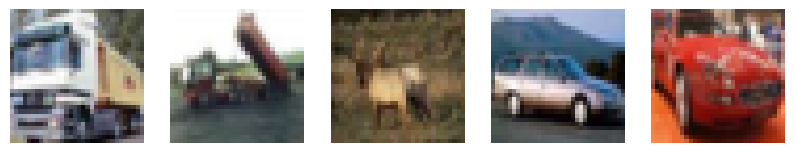

Shape of an image: (3, 32, 32)


In [45]:
x_train_val_np_color, y_train_val_np_color = load_cifar10(train=True, color=True)
x_test_np_color, y_test_np_color = load_cifar10(train=False, color=True)
plot_images(x_train_val_np_color, y_train_val_np_color, rows=1, cols=5, color=True)
print(f'Shape of an image: {x_train_val_np_color[0].shape}')

In [46]:
### Solution to Exercise 10

class LeNet5Color(nn.Module):
    def __init__(self, num_classes=10):
        super(LeNet5Color, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 6, kernel_size=5, stride=1, padding=0),  # MODIFICATION HERE ONLY : Input has 3 channels
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(400, 120)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(120, 84)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(84, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.flatten(out)
        out = self.fc(out)
        out = self.relu(out)
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        return out

## Exercise 11
Split the data, create dataloaders, train an instance of `LeNet5Color`, and compare it with `LeNet5` using the test set.

In [47]:
### Solution to Exercise

# Split the data
x_train_np_color, x_val_np_color, y_train_np_color, y_val_np_color = train_test_split(
    x_train_val_np_color, y_train_val_np_color, train_size=40_000, 
    stratify=y_train_val_np_color, random_state=42)

In [48]:
### Solution to Exercise 11

# Transformation of data to tensor for manipulation with PyTorch
x_train_color = torch.from_numpy(x_train_np_color).to(dtype=torch.float32)
y_train_color = torch.from_numpy(y_train_np_color).to(dtype=torch.int64)
x_val_color = torch.from_numpy(x_val_np_color).to(dtype=torch.float32)
y_val_color = torch.from_numpy(y_val_np_color).to(dtype=torch.int64)
x_test_color = torch.from_numpy(x_test_np_color).to(dtype=torch.float32)
y_test_color = torch.from_numpy(y_test_np_color).to(dtype=torch.int64)

#Creation of dataloader for training, validation and test sets
train_dataloader2 = DataLoader(CustomDataset(x_train_color, y_train_color), batch_size=64, shuffle=True)
validation_dataloader2 = DataLoader(CustomDataset(x_val_color, y_val_color), batch_size=64, shuffle=True)
test_dataloader2 = DataLoader(CustomDataset(x_test_color, y_test_color), batch_size=64, shuffle=True)

In [49]:
### Solution to Exercise 11

#Creation of the LeNet5 model object
modelLeNet5Color = LeNet5Color().to(device)
loss_fn = nn.CrossEntropyLoss() #choose cross entropy loss
optimizer = torch.optim.Adam(modelLeNet5Color.parameters(), lr=1e-3) #choose learning rate at 1e-3

In [50]:
### Solution to Exercise 11

# Training the LeNet5 model for 5 epochs
do_epochs(
    model=modelLeNet5Color,
    loss_fn=loss_fn,
    optimizer=optimizer,
    device=device,
    train_dataloader=train_dataloader2,
    test_dataloader=test_dataloader2,
    epochs=10)

Epoch 1
---------------------
loss: 2.313484  [   64 / 40000]
loss: 1.624957  [ 6464 / 40000]
loss: 1.445046  [12864 / 40000]
loss: 1.546689  [19264 / 40000]
loss: 1.483902  [25664 / 40000]
loss: 1.253821  [32064 / 40000]
loss: 1.302045  [38464 / 40000]

Test set: 
  Accuracy: 49.5%, Avg loss: 1.387416 

Epoch 2
---------------------
loss: 1.296285  [   64 / 40000]
loss: 1.523398  [ 6464 / 40000]
loss: 1.289726  [12864 / 40000]
loss: 1.324071  [19264 / 40000]
loss: 1.223495  [25664 / 40000]
loss: 1.400558  [32064 / 40000]
loss: 1.456233  [38464 / 40000]

Test set: 
  Accuracy: 54.4%, Avg loss: 1.296428 

Epoch 3
---------------------
loss: 1.267114  [   64 / 40000]
loss: 1.119079  [ 6464 / 40000]
loss: 1.250340  [12864 / 40000]
loss: 1.222034  [19264 / 40000]
loss: 0.951620  [25664 / 40000]
loss: 1.145148  [32064 / 40000]
loss: 1.212294  [38464 / 40000]

Test set: 
  Accuracy: 58.2%, Avg loss: 1.169376 

Epoch 4
---------------------
loss: 1.106560  [   64 / 40000]
loss: 1.092519  [ 64

## The LeNet5Color model performs better than the LeNet5, MLP5BN and MLP5 model because of accuracy.
- MLP5 accuracy is 34.2% at the last epoch. 
- MLP5BN accuracy is 42.0% at the last epoch.
- LeNet5 accuracy is 62.1% at the last epoch.
- LeNet5Color accuracy is 63.4% at the last epoch.

## Exercise 12
- Randomly take 10 examples from each class of CIFAR10 to make a subset (*) of the dataset.
- Load this model ResNet18 pre-trained on ImageNet v1 which is available from `torchvision.models`. See [this](https://pytorch.org/vision/stable/models.html) and [this documentation](https://pytorch.org/vision/stable/models/generated/torchvision.models.resnet18.html#torchvision.models.resnet18).
- Fine-tune the pre-trained model for 10-class classification with your subset (from (*)) of CIFAR10 (with colors). Train the model for 5 epochs.
- You may need to carefully read [this documentation](https://pytorch.org/vision/stable/models/generated/torchvision.models.resnet18.html#torchvision.models.resnet18) to do the right data pre-processing.

For this exercise, what is important is to have correct code. The final accuracy is less important, so you don't need to spend too much time on tuning hyper-parameters. There is a big difference in the image sizes, and it is challenging to make this transfer learning successful.

In [141]:
### Solution to Exercise 12

### Creation of the subset dataset

# Definition of a function which create subsets with 10 examples from each 10 classes

def create_subset(data, labels, num_per_class=10):
    unique_labels = np.unique(labels)
    subset_data = []
    subset_labels = []
    
    for label in unique_labels:
        indices = np.where(labels == label)[0]
        np.random.shuffle(indices)
        selected_indices = indices[:num_per_class]
        
        subset_data.append(data[selected_indices])
        subset_labels.extend([label] * num_per_class)
    
    subset_data = np.concatenate(subset_data, axis=0)
    subset_labels = np.array(subset_labels)
    
    return subset_data, subset_labels


# Create subsets for the training, validation, and test datasets

x_train_col_subset, y_train_col_subset = create_subset(x_train_color, y_train_color)
x_val_col_subset, y_val_col_subset = create_subset(x_val_color, y_val_color)
x_test_col_subset, y_test_col_subset = create_subset(x_test_color, y_test_color)

In [142]:
### Solution to Exercise 12

# Convert the subsets to PyTorch tensors

x_train_col_subset = torch.from_numpy(x_train_col_subset).to(dtype=torch.float32)
y_train_col_subset = torch.from_numpy(y_train_col_subset).to(dtype=torch.int64)
x_val_col_subset = torch.from_numpy(x_val_col_subset).to(dtype=torch.float32)
y_val_col_subset = torch.from_numpy(y_val_col_subset).to(dtype=torch.int64)
x_test_col_subset = torch.from_numpy(x_test_col_subset).to(dtype=torch.float32)
y_test_col_subset = torch.from_numpy(y_test_col_subset).to(dtype=torch.int64)

In [143]:
### Solution to Exercise 12

# Create Dataloaders for the subsets

train_dataloader_col_subset = DataLoader(CustomDataset(x_train_col_subset, y_train_col_subset), batch_size=64, shuffle=True)
validation_dataloader_col_subset = DataLoader(CustomDataset(x_val_col_subset, y_val_col_subset), batch_size=64, shuffle=True)
test_dataloader_col_subset = DataLoader(CustomDataset(x_test_col_subset, y_test_col_subset), batch_size=64, shuffle=True)

In [144]:
### Solution to Exercise 12

import torchvision.models as models

# Load the pre-trained ResNet-18 model
resnet18 = models.resnet18(pretrained=True)

# Modify the final fully connected layer for 10 classes
num_ftrs = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_ftrs, 10)

# Define a loss function and optimizer
loss_fn = nn.CrossEntropyLoss() # choose cross entropy loss function
optimizerSGD = torch.optim.SGD(resnet18.parameters(), lr=1e-3, momentum=0.9)
optimizerAdam = torch.optim.Adam(resnet18.parameters(), lr=1e-3)

train_dataset = CustomDataset(x_train_col_subset, y_train_col_subset)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

/opt/mamba/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/mamba/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [145]:
### Solution to Exercise 12

# Training the LeNet5 model for 5 epochs with SGD optimizer
do_epochs(
    model=resnet18,
    loss_fn=loss_fn,
    optimizer=optimizerSGD,
    device=device,
    train_dataloader=train_dataloader_col_subset,
    test_dataloader=test_dataloader_col_subset,
    epochs=5)

Epoch 1
---------------------
loss: 2.641489  [   64 /   100]

Test set: 
  Accuracy: 9.0%, Avg loss: 2.518929 

Epoch 2
---------------------
loss: 2.351585  [   64 /   100]

Test set: 
  Accuracy: 12.0%, Avg loss: 2.436461 

Epoch 3
---------------------
loss: 1.840243  [   64 /   100]

Test set: 
  Accuracy: 6.0%, Avg loss: 2.383144 

Epoch 4
---------------------
loss: 1.385954  [   64 /   100]

Test set: 
  Accuracy: 7.0%, Avg loss: 2.311705 

Epoch 5
---------------------
loss: 1.108216  [   64 /   100]

Test set: 
  Accuracy: 11.0%, Avg loss: 2.269379 

Done!


In [146]:
### Solution to Exercise 12

# Training the LeNet5 model for 5 epochs with Adam optimizer
do_epochs(
    model=resnet18,
    loss_fn=loss_fn,
    optimizer=optimizerAdam,
    device=device,
    train_dataloader=train_dataloader_col_subset,
    test_dataloader=test_dataloader_col_subset,
    epochs=5)

Epoch 1
---------------------
loss: 0.846418  [   64 /   100]

Test set: 
  Accuracy: 29.0%, Avg loss: 2.126877 

Epoch 2
---------------------
loss: 0.834293  [   64 /   100]

Test set: 
  Accuracy: 27.0%, Avg loss: 2.091522 

Epoch 3
---------------------
loss: 0.208018  [   64 /   100]

Test set: 
  Accuracy: 25.0%, Avg loss: 2.121884 

Epoch 4
---------------------
loss: 0.070009  [   64 /   100]

Test set: 
  Accuracy: 26.0%, Avg loss: 2.109535 

Epoch 5
---------------------
loss: 0.013909  [   64 /   100]

Test set: 
  Accuracy: 25.0%, Avg loss: 2.094159 

Done!
